# Dimensionsreduzierung

In [1]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

## Feature Selection

- Die Freitextfelder (d. h. "Lieblingssportart", "Lieblingsessen" & "Lieblings-Musiker*in") werden für die Dimensionsreduzierung entfernt
- Begründungen
    - Durch die Umwandlung in numerische Werte per One-Hot-Encoding könnten diese theoretisch für Berechnung genutzt werden. Da fast alle Angaben aber nur einmal auftauchen, gibt es hier häufig starke Korrelationen
        - Bsp.: Eine Person hat als einzige eine bestimmte Lieblingssportart & Lieblingsessen angegeben, die dadurch vermeintlich stark miteinander korrelieren
    - Da immer nur eine Angabe pro "Lieblingssportart"/"Lieblingsessen"/"Lieblings-Musiker*in" möglich war, sind die Angaben bei allen anderen Features der Kategorie "0", wodurch der Informationsgehalt der Features sehr gering ist

- (Fast) Alle weiteren Features sind durch Fragestellung auf Werte von 1-5 beschränkt, wodurch keine weiteren Features offensichtlich irrelevant wären...

In [3]:
data_numerical = data.copy().select_dtypes(include='number')

### Skalieren der Daten

Da fast alle Fragen einen Zahlenraum von 1-5 vorgegeben hatten, müsste hierfür eigentlich keine Skalierung durchgeführt werden. Trotzdem skalieren wir die Daten, insb. aus den folgenden Gründen:

- Einzelne Features wie z. B. "Alter" machen eine Skalierung notwendig, da Clustering-Algorithmen sonst verschiedene Zahlenräume vergleichen würde
- Wenn in Zukunft weitere/andere Features (z. B. mit Zahlenraum von 1-10) eingeführt werden, sind die dargestellten Ansätze trotzdem langfristig nutzbar

In [4]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numerical), columns=data_numerical.columns)

data_scaled.shape

(62, 56)

## Standard PCA

In [5]:
# Angabe der gewünschten Dimensionen
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data_scaled)
X_pca.shape

(62, 3)

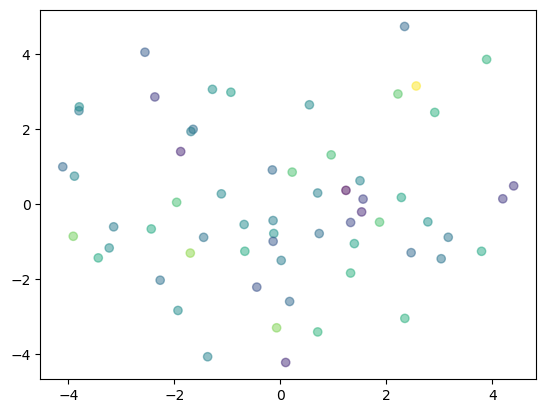

In [6]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=X_pca[:,2], alpha=0.5)

## Kernel-PCA

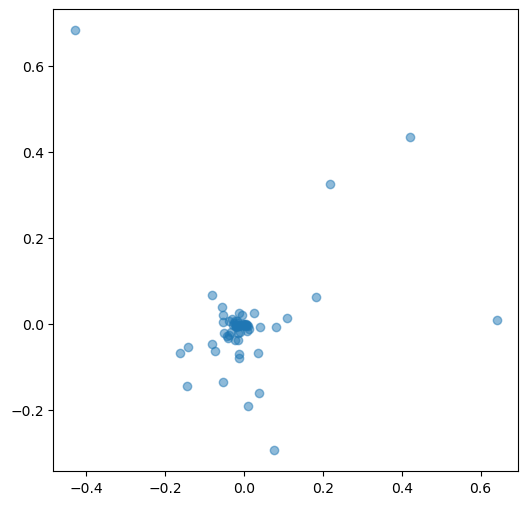

In [7]:
# Angabe der gewünschten Dimensionen
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=10)
X_kpca = kpca.fit_transform(data_scaled)
X_kpca

fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_kpca[:,0], X_kpca[:,1], alpha=0.5)

## t-SNE

In [8]:
tsne = TSNE(perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(data_scaled)
X_tsne.T

array([[-0.69405687, -0.79765165, -1.5896147 ,  0.03760719, -0.15373576,
        -0.18905172, -1.115397  , -0.80233693, -0.60014987, -0.59602654,
        -0.5328714 ,  0.22217715, -1.406957  , -0.08245122,  0.11553487,
        -0.1406774 , -0.94014287, -0.89052296, -1.3239375 , -0.14236447,
        -0.4872988 , -0.7400696 , -0.3275008 , -0.6250821 ,  0.10629334,
        -0.5960993 , -0.8816482 , -0.80599105, -0.63249993, -1.2128514 ,
        -0.7198583 , -0.40418047, -0.1850997 , -0.28384852,  0.03212174,
        -1.0962695 , -0.4699017 , -1.0640811 , -1.3686651 ,  0.06148239,
        -0.18061978, -1.7566881 , -0.81346303, -1.3394248 , -1.011135  ,
        -0.7408037 ,  0.08775586, -0.06127157, -0.59648126, -0.41086632,
        -0.75294405, -1.0213131 , -0.7041282 , -0.19685699, -0.34079424,
        -1.0988255 ,  0.24708934, -1.4493064 , -0.7308706 , -0.69117725,
        -0.95182973,  0.4458639 ],
       [ 1.1682488 ,  1.3321284 ,  1.2729965 ,  1.5755262 ,  0.89934576,
         1.32401

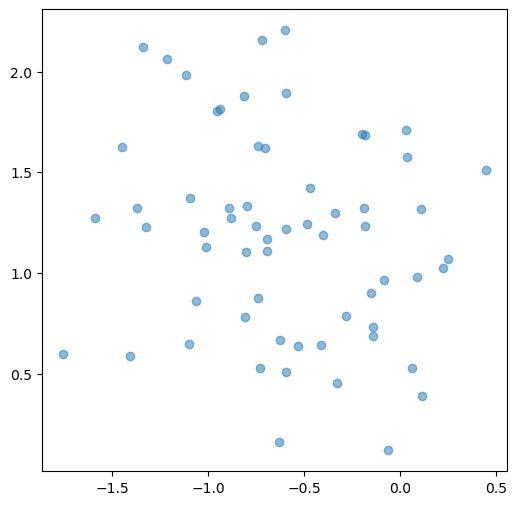

In [9]:
fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)

## Dimensionsreduzierung nach Kategorien

Durch Entfernen nicht-numerischer Features entfernte Spalten...

In [10]:
data_numerical.columns
set(data.columns) - set(data_numerical.columns)

{'Bitte gib hier ein Pseudonym ein und merke dir dieses\n(z.B. Kürzel, Zahlencode, etc.). Damit können nach Abschluss des Projektes der eigene "Datenpunkt" gefunden werden. Das Pseudonym wird für Andere sichtbar sein.',
 'Geschlecht',
 'Was ist dein Lieblingsessen? (nur eines angeben)',
 'Was ist deine Lieblingsband bzw. dein/e Lieblings-Musiker*in?\n(nur eine/n angeben)',
 'Was ist deine absolute Lieblingssportart?',
 'Welchem Studiengang fühlst du dich am meisten zugehörig?',
 'Welcher Funktion an der HSD fühlst du dich am meisten\nzugehörig?'}

In [11]:
short_labels = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang", "sportlichkeit", "lieblingssportart",
          "ernaehrung", "essengehen", "kochen", "feiern", "lieblingsessen", "musik", "lieblingsmusiker", "lesen", "schauspiel",
          "filme", "malen", "museumsbesuche", "videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften",
          "freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig",
          "abenteuerlustig", "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren",
          "letzter_druecker", "neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld",]

In [12]:
# Ursprüngliche Kategorien
# cat_demography = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang"]

# Nach entfernen nicht-numerischer Werte
cat_demography = ("Demographie", ["alter"])

cat_sport = ("Sport", ["sportlichkeit", "ernaehrung", "essengehen", "kochen", "feiern",
 "sportarten_Basketball",
 "sportarten_Bouldern/Klettern",
 "sportarten_Football",
 "sportarten_Fußball",
 "sportarten_Handball",
 "sportarten_Hockey",
 "sportarten_Kampfsport",
 "sportarten_Leichtathletik",
 "sportarten_Reiten",
 "sportarten_Rennrad/Mountainbike",
 "sportarten_Schwimmen",
 "sportarten_Tanzen",
 "sportarten_Tennis",
 "sportarten_Volleyball",
 "sportarten_Wassersport",
 "sportarten_Wintersport",
 "sportarten_Yoga"])

cat_creativity = ("Kreativität", ["musik", "lesen", "schauspiel", "filme", "malen", "museumsbesuche"])

cat_science =       ("Wissenschaft", ["videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften"])
cat_social =        ("Sozialer Umgang", ["freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig", "abenteuerlustig"])
cat_study =         ("Studienverhalten", [ "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren", "letzter_druecker"])
cat_personality =   ("Persönlichkeit", ["neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld"])

all_categories = [cat_demography, cat_sport, cat_creativity, cat_science, cat_social, cat_study, cat_personality]
all_categories


[('Demographie', ['alter']),
 ('Sport',
  ['sportlichkeit',
   'ernaehrung',
   'essengehen',
   'kochen',
   'feiern',
   'sportarten_Basketball',
   'sportarten_Bouldern/Klettern',
   'sportarten_Football',
   'sportarten_Fußball',
   'sportarten_Handball',
   'sportarten_Hockey',
   'sportarten_Kampfsport',
   'sportarten_Leichtathletik',
   'sportarten_Reiten',
   'sportarten_Rennrad/Mountainbike',
   'sportarten_Schwimmen',
   'sportarten_Tanzen',
   'sportarten_Tennis',
   'sportarten_Volleyball',
   'sportarten_Wassersport',
   'sportarten_Wintersport',
   'sportarten_Yoga']),
 ('Kreativität',
  ['musik', 'lesen', 'schauspiel', 'filme', 'malen', 'museumsbesuche']),
 ('Wissenschaft',
  ['videospiele',
   'social_media',
   'technologie',
   'astronomie',
   'naturwissenschaften']),
 ('Sozialer Umgang',
  ['freiwilligenarbeit',
   'soziales',
   'introvertiert',
   'fomo',
   'spontan',
   'verwirrt',
   'gluecklich',
   'geduldig',
   'streitlustig',
   'abenteuerlustig']),
 ('St

In [13]:
# Helper-method to perform dimensionality reduction for given data and reduction model on predefined categories
# Input:
#   - data: DataFrame to be reduced
#   - model: Model which is used to perform reduction; Has to support the .fit_transform()-function
# Output: DataFrame, which used the given model to reduce the data to the predefined categories

def compute_categories(data, model):
    data_reduced = pd.DataFrame(columns=[category[0] for category in all_categories])
    for category in all_categories:
        model_trained = model.fit_transform(data[[columns[x] for x in category[1]]])
        data_reduced[category[0]] = model_trained[:,0]
    return data_reduced

### PCA

In [14]:
pca = PCA(n_components=1)

data_reduced_PCA = compute_categories(data_scaled, pca)
data_reduced_PCA

,Demographie,Sport,Kreativität,Wissenschaft,Sozialer Umgang,Studienverhalten,Persönlichkeit
0,0.555073,-1.045241,-0.063565,-1.481797,0.405950,-1.635010,0.730060
1,0.105210,-0.775327,-0.850067,1.617876,-0.517746,-1.494638,-0.224172
2,-0.344653,2.200932,-1.671769,-0.669291,-1.797866,-1.035561,-1.429170
3,-0.569585,-1.387377,1.363657,0.105325,0.121731,-0.903822,1.204482
4,-0.344653,-0.566647,0.823353,-2.294303,-0.164162,2.018491,-0.347283
...,...,...,...,...,...,...,...
57,0.105210,2.237052,-3.023933,-1.345619,-0.158858,-2.657732,0.060967
58,-0.794517,0.332908,3.230977,-1.985446,0.103726,0.038180,0.662259
59,-0.119722,-0.531107,-0.778620,-1.918051,-0.498246,1.668469,2.008838
60,1.229868,0.838900,-3.183976,1.385794,-0.388389,-1.960236,1.699726


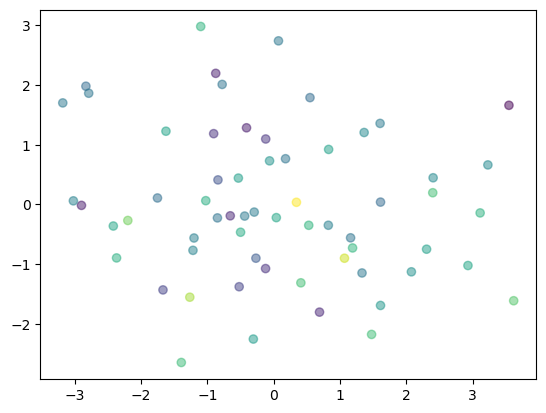

In [15]:
plt.scatter(data_reduced_PCA["Kreativität"], data_reduced_PCA["Persönlichkeit"], c=data_reduced_PCA["Sozialer Umgang"], alpha=0.5)

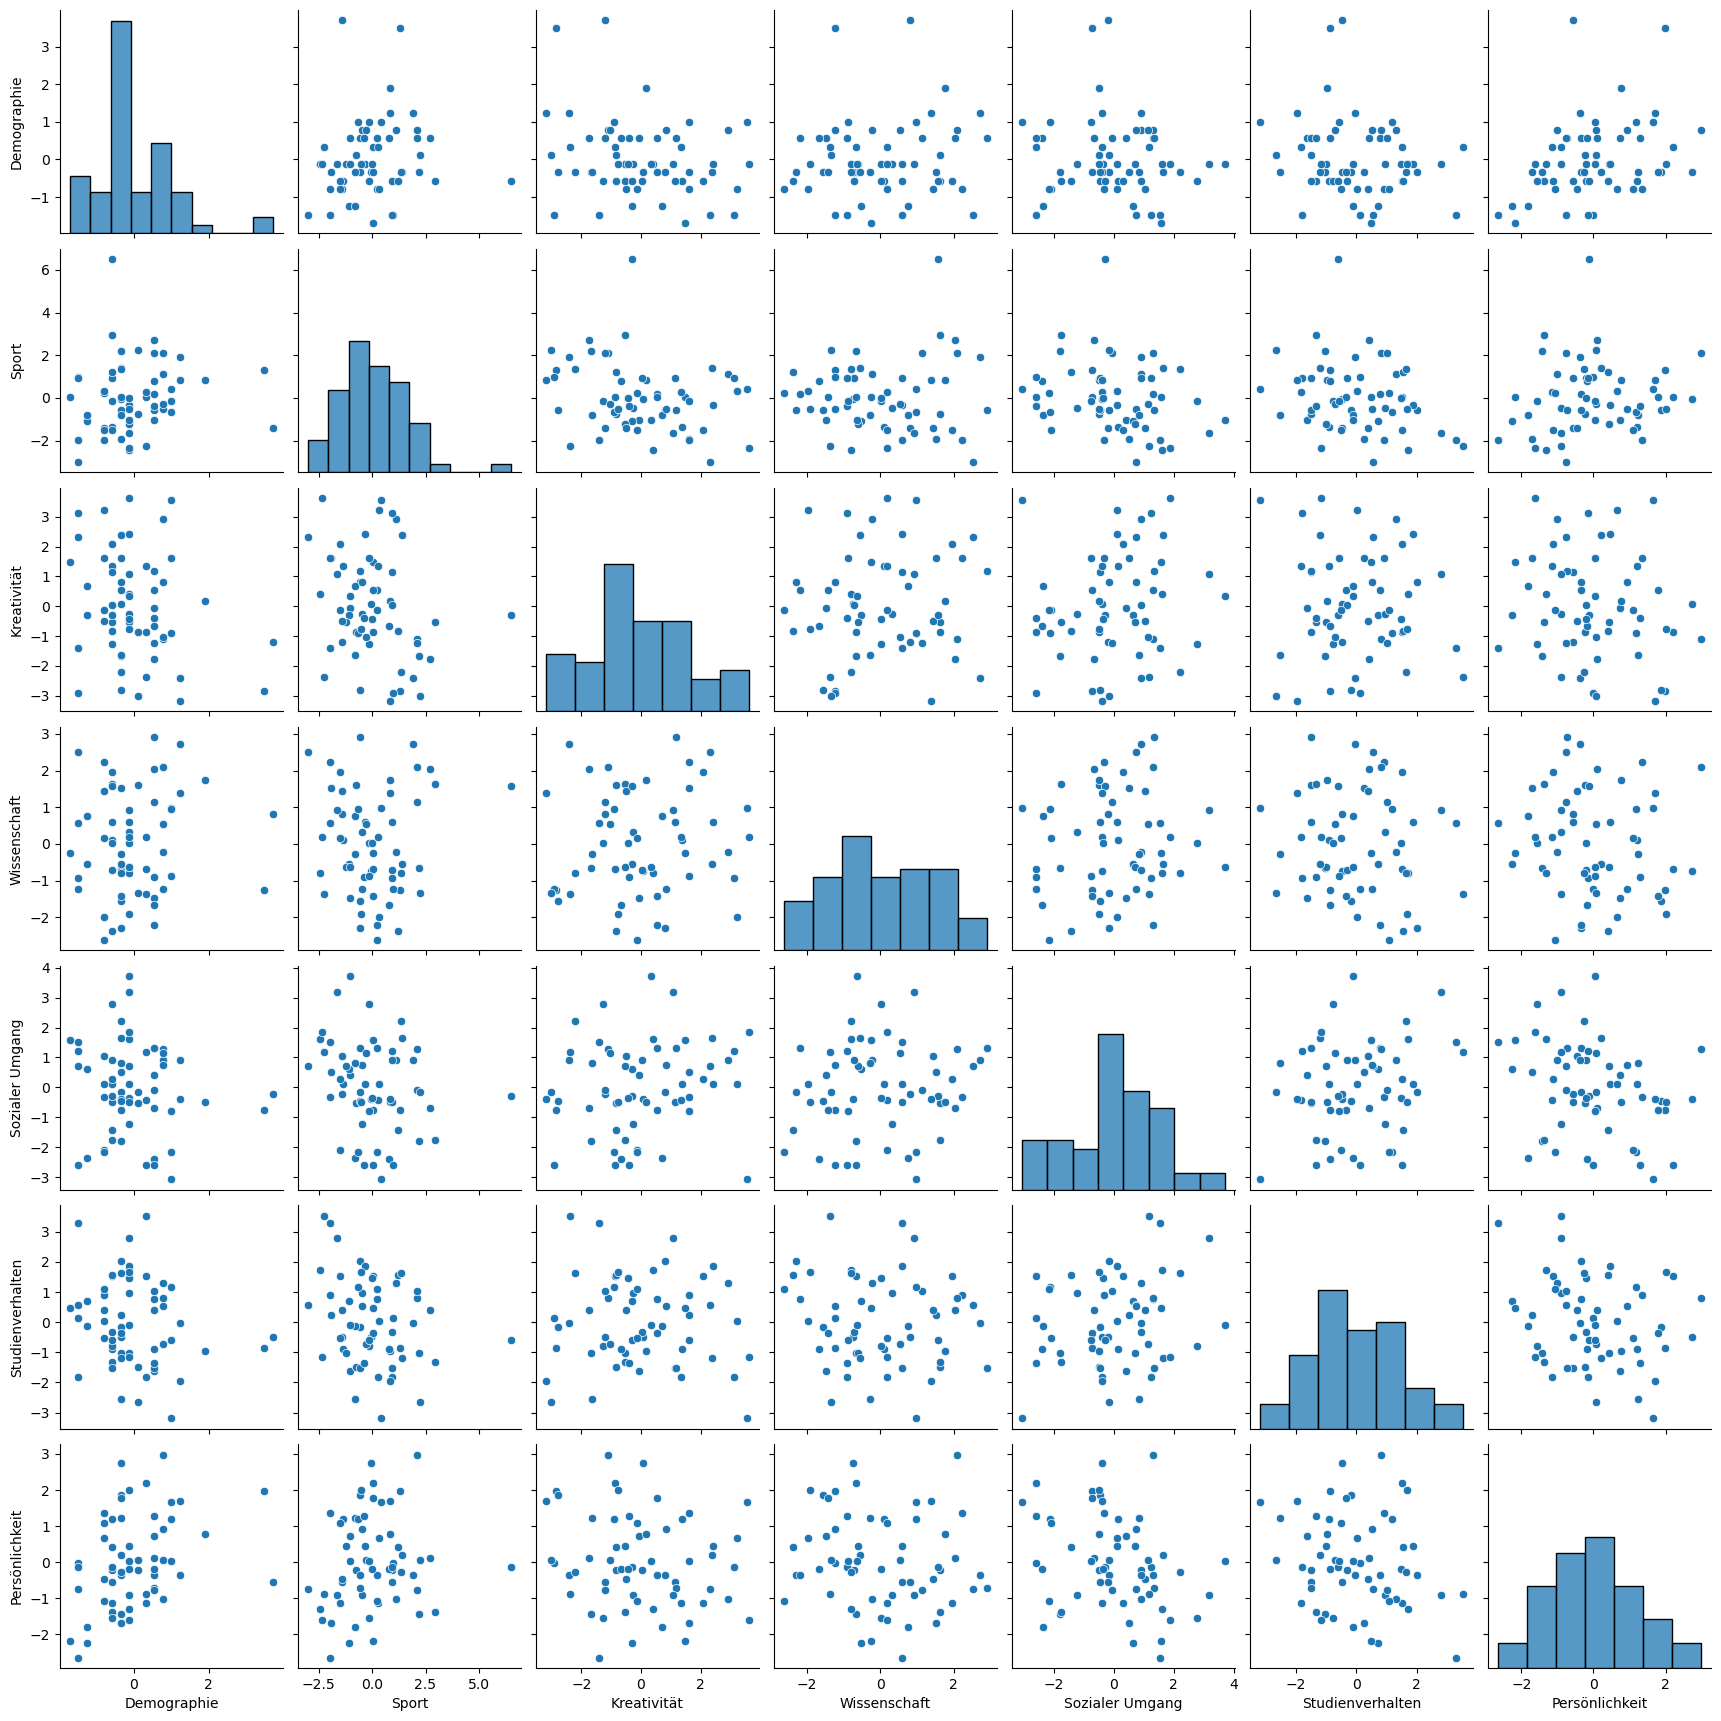

In [16]:
sb.pairplot(data_reduced_PCA)

### Kernel PCA

In [17]:
kpca = KernelPCA(n_components=1, kernel="rbf", gamma=1)

data_reduced_kPCA = compute_categories(data_scaled, kpca)
data_reduced_kPCA

,Demographie,Sport,Kreativität,Wissenschaft,Sozialer Umgang,Studienverhalten,Persönlichkeit
0,0.649521,-0.029008,-0.072323,0.354519,-0.036199,-0.065395,0.008775
1,0.178282,-0.029008,-0.026302,-0.312151,-0.035542,0.680684,0.609035
2,-0.339394,-0.029008,-0.020185,0.394759,-0.035668,-0.023958,-0.008565
3,-0.503842,-0.029008,0.005427,0.013175,-0.037286,0.428626,0.026250
4,-0.339394,0.045535,-0.001480,-0.003015,-0.036315,-0.051439,0.008487
...,...,...,...,...,...,...,...
57,0.178282,-0.029008,-0.152107,0.038677,-0.035960,0.003806,-0.432017
58,-0.577100,-0.029185,-0.002770,-0.039669,-0.035643,-0.027941,0.040524
59,-0.099483,-0.029008,-0.067518,-0.023556,-0.035577,-0.026121,0.009827
60,0.720762,-0.029008,-0.175349,-0.085935,-0.037522,0.010576,0.052436


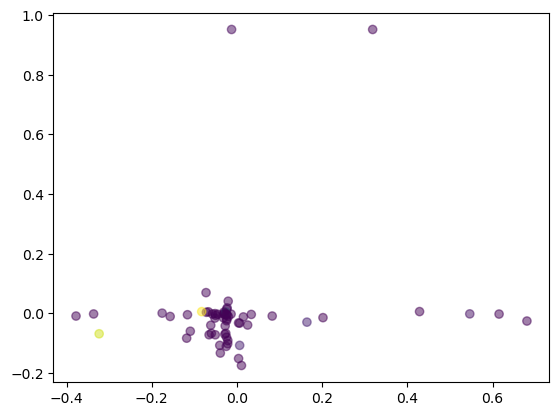

In [18]:
# plt.scatter(data_reduced_PCA["Kreativität"], data_reduced_PCA["Persönlichkeit"], c=data_reduced_PCA["Sozialer Umgang"], alpha=0.5)
plt.scatter(data_reduced_kPCA["Studienverhalten"], data_reduced_kPCA["Kreativität"], c=data_reduced_kPCA["Sozialer Umgang"], alpha=0.5)

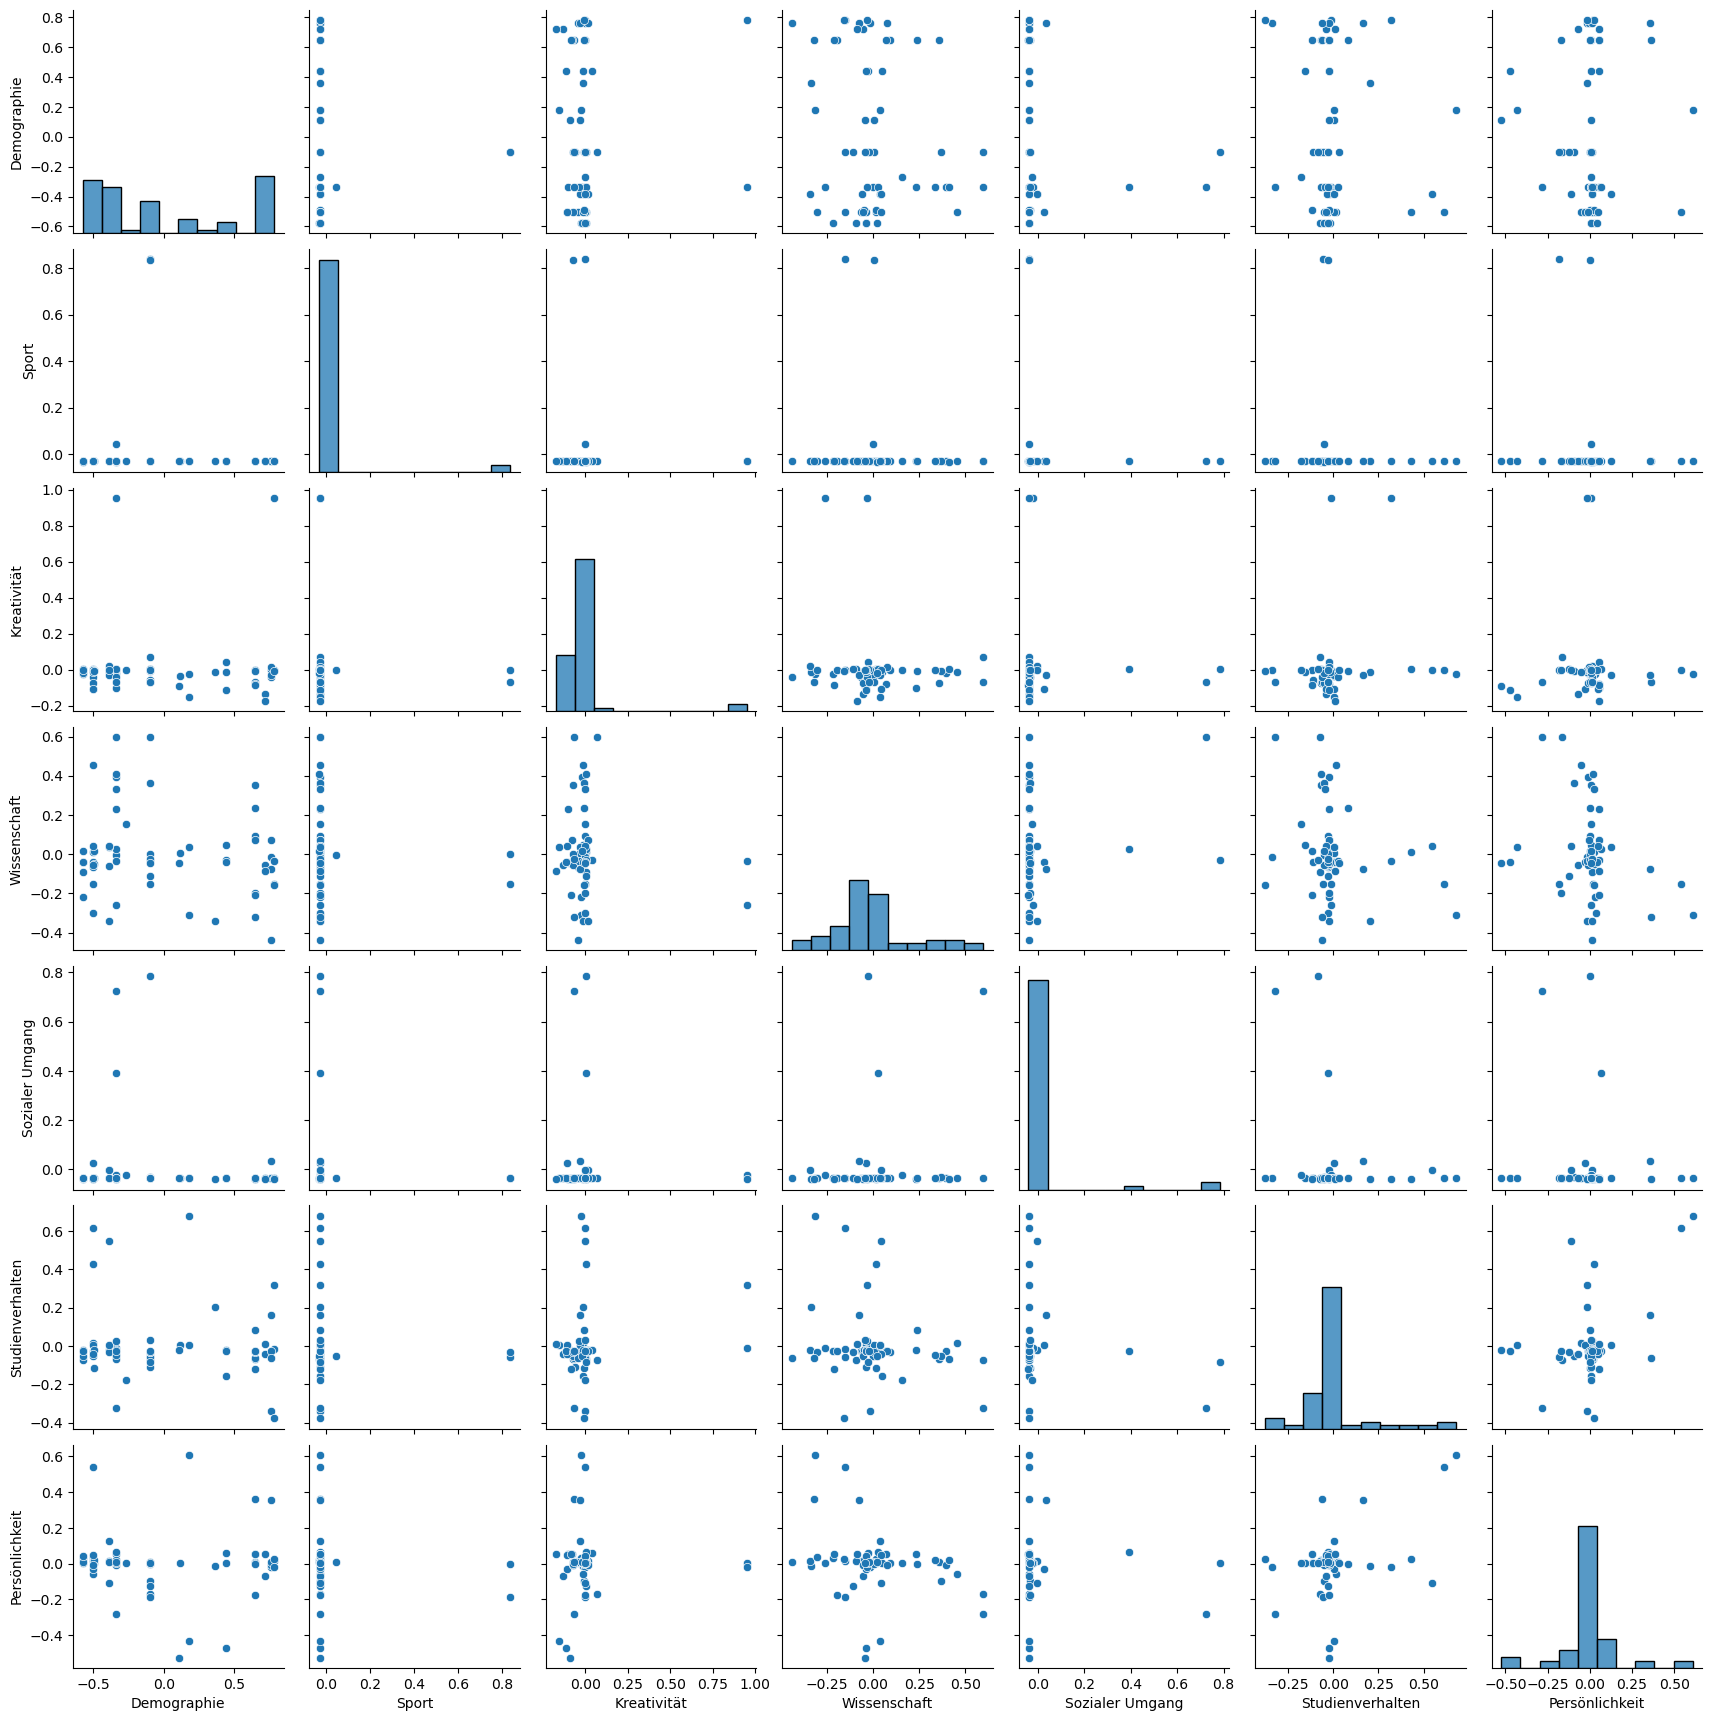

In [19]:
sb.pairplot(data_reduced_kPCA, diag_kws = {"bins": 10})

### t-SNE

In [20]:
tsne = TSNE(n_components=1, perplexity=50, random_state=0)

data_reduced_tsne = compute_categories(data_scaled, tsne)
data_reduced_tsne

,Demographie,Sport,Kreativität,Wissenschaft,Sozialer Umgang,Studienverhalten,Persönlichkeit
0,-413.811157,0.830826,-1.127216,1.950580,0.876601,3.966310,4.031176
1,106.549850,0.846164,-1.470071,0.593220,0.639031,4.140762,3.190333
2,-276.811249,1.702856,-1.841605,1.627224,0.122093,3.923307,2.952388
3,23.524115,1.402032,-0.367725,1.306589,1.088734,4.314629,3.989380
4,-276.811249,0.998407,-0.533532,2.299694,0.741661,5.721639,3.008187
...,...,...,...,...,...,...,...
57,106.549850,-0.000097,-2.164667,2.031048,1.111992,3.775572,3.498195
58,-67.861549,0.827259,0.207322,2.501128,0.560037,4.833886,3.569905
59,-165.152588,0.832976,-1.430902,2.341027,0.603495,5.489359,4.237892
60,247.502502,1.056033,-2.182725,0.590345,0.800353,4.027880,4.029497


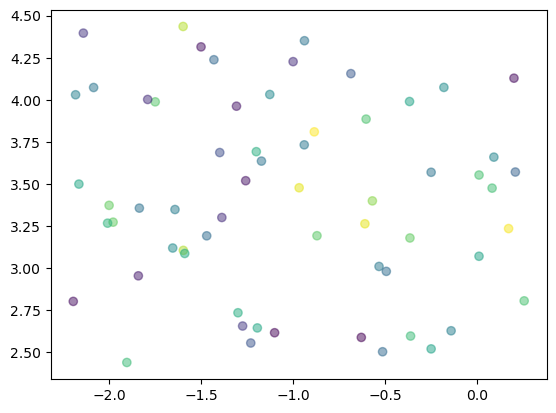

In [21]:
plt.scatter(data_reduced_tsne["Kreativität"], data_reduced_tsne["Persönlichkeit"], c=data_reduced_tsne["Sozialer Umgang"], alpha=0.5)

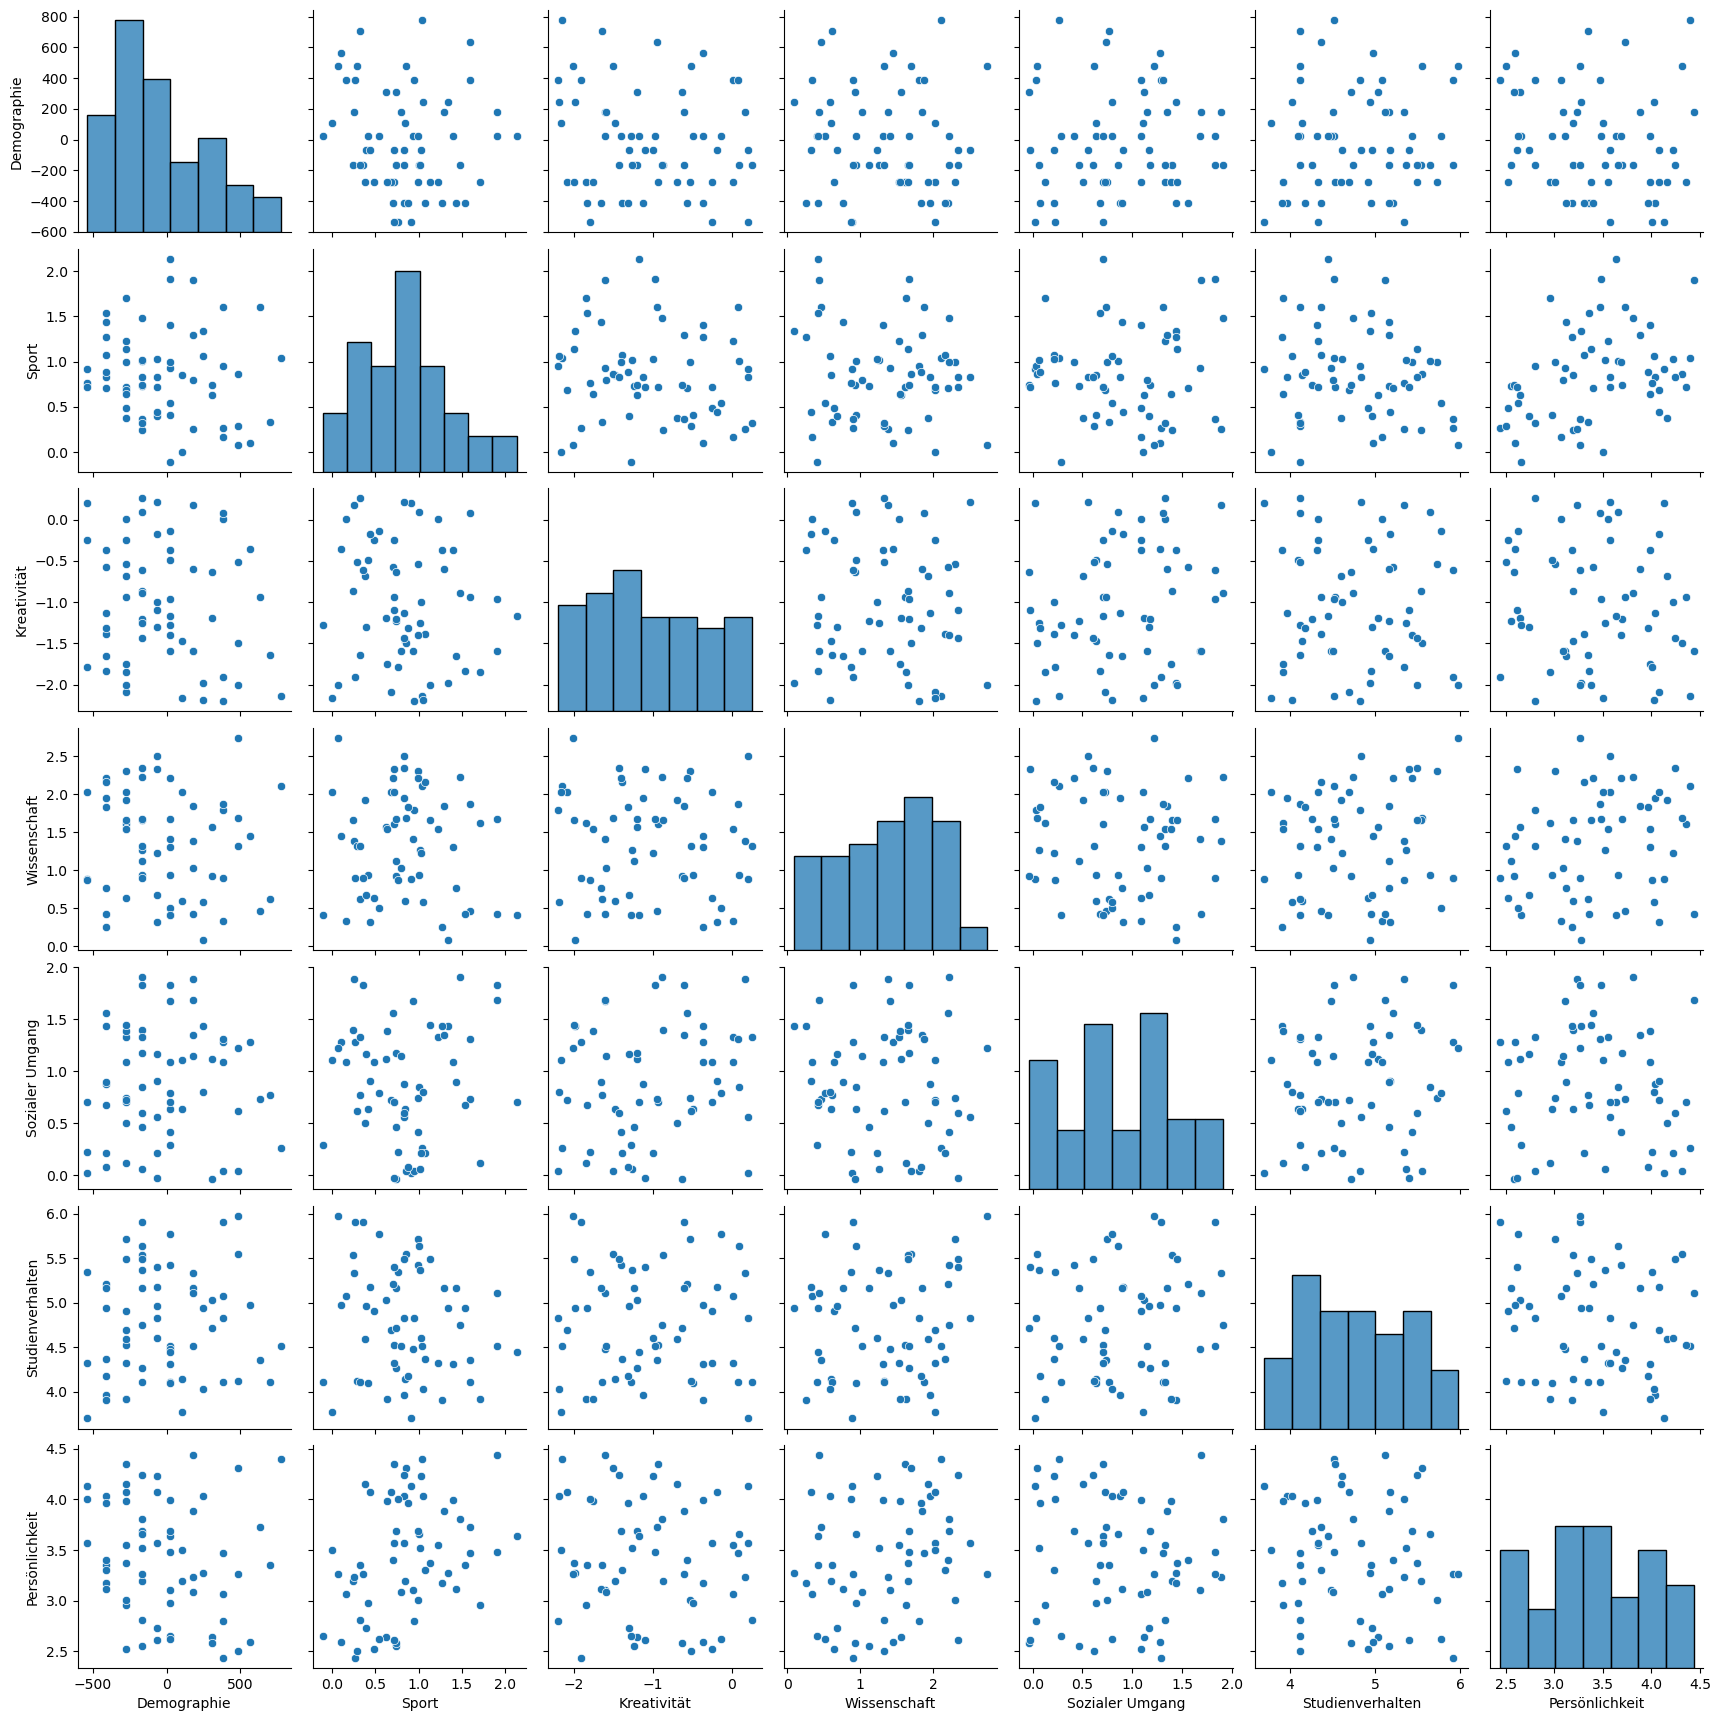

In [22]:
sb.pairplot(data_reduced_tsne)